In [100]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


""" 

Run Equilibrium Propagation / Backpropagation on Nanowire Networks for classification. 

Author: Alon Loeffler

Required Files/Folders: learning_functions.py | edamame | asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00.mat

"""

#IMPORTS:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
import os

sys.path.append('/import/silo2/aloe8475/Documents/edamame') #point to edamame locally
sys.path.append('/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp') #point to edamame locally

fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00'
# fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00'

#point to network data path ^ 

saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/' 
dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/'

#import edamame (neuromorphic nanowire python package by Ruomin Zhu)
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import loadmat, savemat
import networkx as nx
from tqdm.notebook import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace

import pickle 
import _pickle as cPickle
import gzip

from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph
from learning_functions import calc_cost,setupStimulus,setupSourcesOnly,runTesting,getNWState,calcOutputs

" Create Inputs "
def createSimpleInputs(patternSize=3,numSamples=10,noise=False):
    #SIMPLE ROW INPUTS:
    np.random.seed(42)
    
    if patternSize==2:
    #2x2 pattern:
        orig_inputs=np.array((np.array([1,0,1,0]),np.array([0,1,0,1])))
    elif patternSize==3:
        #3x3 pattern:
        orig_inputs=np.array((np.array([1,0,1,0,1,0,1,0,1]),np.array([0,1,0,1,1,1,0,1,0])))
    orig_inputs=orig_inputs.astype('double')
    samples=[[] for i in range(len(orig_inputs))]
    new_inputs=np.array([orig_inputs]*numSamples)

    #Pattern without Noise
    NoNoiseInputs=[]
    for targetClass in range(len(orig_inputs)):
        NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])
#     set_trace()
    #Make Noisy variants of simple patterns:
    for i in range(len(orig_inputs)):
        for j in range(numSamples):
            randVals=np.random.randint(1,patternSize) #choose how many of the 3 sources will have noise
            noiseVals=np.random.randint(patternSize, size=randVals)
            temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
            if noise:
                for val in noiseVals:
                    temp[val]=np.double(np.random.random(1))
            new_inputs[j][i][new_inputs[j][i]==1]=temp
    #         samples[i].append(temp)
    
    #RESHAPE INPUTS INTO numSamplesx2
    row1=[]
    row2=[]
    for i in range(len(new_inputs)):
        row1.append(new_inputs[i][0])
        row2.append(new_inputs[i][1])

    inputs=np.array([row1,row2])
    inputs=inputs.reshape(numSamples*2,orig_inputs.shape[1])
    targets=np.zeros(numSamples*2)
    targets[-numSamples:]=1

    #change 0 volts to 0.05
#     minVoltage=0.005
#     inputs=inputs+minVoltage
    
    return inputs, targets,orig_inputs

" Load Networks "
def buildNetworks(fileName,ManualSources=True,numDrains=2,numSources=9):
    #load data
    nw=loadmat(fileName)
    nwSize = nw['number_of_wires'][0][0]
    print('Network '+str(nwSize)+ ' Loaded')
#     this_seed=8639
    Network=nw
    connectivity=connectivity__(wires_dict=Network) 

    #fixing file structure from Matlab:
    connectivity.avg_length=connectivity.avg_length[0][0]
    connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
    connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
    connectivity.dispersion=connectivity.dispersion[0][0]
    # connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
    connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
    connectivity.length_x=connectivity.length_x[0][0]
    connectivity.length_y=connectivity.length_y[0][0]
    connectivity.number_of_wires=connectivity.number_of_wires[0][0]
    connectivity.numOfWires=connectivity.numOfWires[0][0]
    connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
    connectivity.theta=connectivity.theta[0][0]
    connectivity.this_seed=connectivity.this_seed[0][0]
    
    #find x and y values of each end of each wire 
    xa=connectivity.xa[0]
    xb=connectivity.xb[0]
    ya=connectivity.ya[0]
    yb=connectivity.yb[0]

    #Pick Electrode placement/distance apart:
    
    #DRAINS
    numDrains=3
    ex=np.zeros(numDrains)*5#*15
    if nwSize > 500:
        eyVal=76
    else:
        eyVal= 51
    ey=np.linspace(-1,eyVal,numDrains)#(-1,101,numDrains)

    elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates


    #IN A LINE:
    if nwSize > 500:
        exVal=75
        eyVal = 74
    else:
        exVal=50
        eyVal=49
    ex=np.ones(numSources)*exVal#50
    ey=np.linspace(-2,eyVal,numSources)#(-2,99,numSources)
    
    #IN A 3X3 GRID:
    # middleNWx=int(connectivity.length_x/2)+1
    # middleNWy=int(connectivity.length_y/2)-1
    # distBwElecs=10
    # ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
    # ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

    elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates


    #Manual Source Placement:
    if ManualSources:
        if numSources==9:
            if nwSize > 500:
                elecSource=[678, 260, 491, 173, 628, 424, 301, 236, 483] #700nws
            else:
                elecSource=[23,320,194,74, 145, 317, 129, 34, 141] #350 nws

        elif numSources == 4:
            elecSource=[320,42,161,141]

    elecDrain=elecDrain[[0,-1]]
    
    return connectivity,elecSource,elecDrain


#ADD BACKPROP

#This function runs each training epoch and saves the network state at the last timestep of that epoch   
def getNWState_backprop(training_stimulus,state,drains,sources,tmpTiming,tmpTargets,limVal,limVal0,limVal1,run_time=2,dt=0.01,disable_tqdm=False):
    eles = np.append(drains, sources) #all drains
    #     if len(eles) == num_drain_training + num_source_training:
    training_sim,cost = runSim_backprop(connectivity, 
                                   stimulus = training_stimulus,
                                   junctionMode = 'tunneling',
                                   dt = dt, T = run_time, 
                                   contactMode = 'preSet',
                                   electrodes = eles,
                                   findFirst = False,
                                   start_state = state,
                                   disable_tqdm=disable_tqdm,
                                   collapse=False,tmpTiming=tmpTiming,tmpTargets=tmpTargets,
                                   limVal=limVal,limVal0=limVal0,limVal1=limVal1)  
    JS1 = getJunctionState(training_sim, -1) #save state
    #     else: 
    #         print('Bless you Joel :)')
    return training_sim,JS1   

#Combine drain voltage change with runSim:
def runSim_backprop(Connectivity, 
                    junctionMode='binary', collapse=False,
                    criticalFlux=0.1, maxFlux=1.5e-1,
                    contactMode='farthest', electrodes=None,
                    dt=1e-3, T=10, 
                    stimulus = None,
                    biasType = 'DC',
                    onTime=0, offTime=50000000,
                    onAmp=1, offAmp=0.005,
                    f = 1, customSignal = None,
                    start_state = None,
                    lite_mode = False, save_steps = 1,
                    findFirst = True,
                    disable_tqdm = False,
                    freeze_wire = None, freeze_junction = None, 
                    freeze_TimeStamp = None,tmpTiming=[],tmpTargets=[],
                    limVal=0.5,limVal0=0.5,limVal1=0.5):

    """
    For the case of multi electrodes, stimulus should be in parameters.
    See help(stimulus__) for how to generate stimulus__ objects.
    """

    SimulationOptions = simulationOptions__(dt = dt, T = T,
                                            connectivity = Connectivity, 
                                            contactMode = contactMode,
                                            electrodes = electrodes)

    if ((contactMode == 'preSet') and (len(electrodes) > 2)) or stimulus is not None:
        from sys import exit
        if stimulus == None:
            logging.warning(f'Multiple electrodes detected. Please input stimulus in parameters!')
            exit()
        if len(stimulus) < len(SimulationOptions.electrodes):
            diff = len(SimulationOptions.electrodes) - len(stimulus)
            for _ in range(diff):
                stimulus.append(stimulus__('Drain', T = T, dt = dt))

        if len(stimulus) > len(SimulationOptions.electrodes):
            logging.warning(f'More stimulus than electrodes. Current setup has {len(SimulationOptions.electrodes)} electrodes!')
            exit()
            
        if len(stimulus[0].signal) < len(SimulationOptions.TimeVector):
            logging.warning(f'Stimulus length not correct, current time vector has length {len(SimulationOptions.TimeVector)}!')
            exit()
        SimulationOptions.stimulus = stimulus
            
    elif contactMode == 'boundary':
        SimulationOptions.stimulus[:int(len(SimulationOptions.electrodes)/2)] = [stimulus__(biasType = biasType, 
                                                                                        T = T, dt = dt,
                                                                                        onTime = onTime, offTime = offTime,
                                                                                        onAmp = onAmp, offAmp = offAmp,
                                                                                        f = f, customSignal= customSignal)
                                                                                        for i in range(int(len(SimulationOptions.electrodes)/2))]
    else:
        SimulationOptions.stimulus[0] = stimulus__(biasType = biasType, 
                                                T = T, dt = dt,
                                                onTime = onTime, offTime = offTime,
                                                onAmp = onAmp, offAmp = offAmp,
                                                    f = f, customSignal= customSignal)
    if start_state == None: 
        JunctionState = junctionState__(Connectivity.numOfJunctions, 
                                    mode = junctionMode, collapse = collapse, 
                                    criticalFlux=criticalFlux, maxFlux = maxFlux)
    else:
        from copy import deepcopy
        JunctionState = deepcopy(start_state)
    
    kwdict = dict()
    if (freeze_wire != None) or (freeze_junction != None):
        kwdict = dict(freeze_wire = freeze_wire,
                    freeze_junction = freeze_junction, 
                    freeze_TimeStamp = freeze_TimeStamp)
        
    this_realization,cost = simulateNetwork_backprop(SimulationOptions, Connectivity, JunctionState,tmpTiming,tmpTargets,limVal,limVal0,limVal1,lite_mode, disable_tqdm, save_steps, **kwdict)
    
#     finalIter=np.max(np.nonzero(this_realization.electrodeCurrent))
#     if finalIter < 199:
#         this_realization.electrodeCurrent=this_realization.electrodeCurrent[:finalIter+1,:]
#         this_realization.junctionVoltage=this_realization.junctionVoltage[:finalIter+1,:]
#         this_realization.junctionConductance=this_realization.junctionConductance[:finalIter+1,:]
#         this_realization.wireVoltage=this_realization.wireVoltage[:finalIter+1,:]
#         this_realization.filamentState=this_realization.filamentState[:finalIter+1,:]
#         this_realization.junctionSwitch=this_realization.junctionSwitch[:finalIter+1,:]
        #final Iter = time , use that to find / save network state
        
        
#         this_realization.TimeVector=this_realization.TimeVector[:finalIter+1,:]

    #     remove zeros from simulations that ended early:
#     this_realization.junctionCurrent
    
    if findFirst:
        from edamame.analysis.GraphTheory import findCurrent
        try:
            activation = findCurrent(this_realization, 1)
            logging.info(f'First current path {activation[0][0]} formed at time = {activation[1][0]} s.')
        except:
            logging.info('Unfortunately, no current path is formed in simulation time.')

    return this_realization,cost

def simulateNetwork_backprop(simulationOptions, connectivity, junctionState,tmpTiming,tmpTargets, limVoltage,limVal0,limVal1,lite_mode = False, disable_tqdm = False, save_steps = 1, **kwargs):
    niterations = simulationOptions.NumOfIterations
    electrodes = simulationOptions.electrodes
    numOfElectrodes = len(electrodes)
    E = connectivity.numOfJunctions
    V = connectivity.numOfWires
    edgeList = connectivity.edge_list
#     onAmp     = simulationOptions.stimulus[3].onAmp
    
#     maxV      = onAmp *limVoltage
    n         = num_drain_training #num of drains
    cost      = []
    beta      = 0.05
    grad      = np.zeros((n)) #set gradients to zero for each epoch  

    Network = network__()
    sampling = np.arange(0, niterations, save_steps)
    if lite_mode:
        Network.connectivity = connectivity__(adjMat = connectivity.adj_matrix)
        Network.filamentState = np.zeros((int(niterations/save_steps), E))
        Network.wireVoltage = np.zeros((int(niterations/save_steps), V))
        Network.electrodeCurrent = np.zeros((int(niterations/save_steps), numOfElectrodes))
        Network.TimeVector = np.zeros(int(niterations/save_steps))
    else:        
        Network.connectivity = connectivity
        Network.TimeVector = simulationOptions.TimeVector
        Network.filamentState = np.zeros((niterations, E))
        Network.junctionVoltage = np.zeros((niterations, E))
        # Network.junctionResistance = np.zeros((niterations, E))
        Network.junctionConductance = np.zeros((niterations, E))
        Network.junctionSwitch = np.zeros((niterations, E), dtype = bool)
        Network.wireVoltage = np.zeros((niterations, V))
        Network.electrodeCurrent = np.zeros((niterations, numOfElectrodes))

    Network.sources = []
    Network.drains = []
    for i in range(numOfElectrodes):
        if np.mean(simulationOptions.stimulus[i].signal) != 0:
            Network.sources.append(electrodes[i])
        else:
            Network.drains.append(electrodes[i])

    if len(Network.drains) == 0:
        Network.drains.append(electrodes[1])

    if 'freeze_wire' in kwargs:
        freeze_wire = kwargs['freeze_wire']
        freeze_TimeStamp = kwargs['freeze_TimeStamp']
    else:
        freeze_TimeStamp = niterations + 1
    
    #Simulation Run:
#     new_time=0
    stopTrain=False
    for this_time in tqdm(range(niterations), desc='Running Simulation ', disable = disable_tqdm): #each time step
        if not stopTrain:
            this_stimulus = np.array([i.signal[this_time] for i in simulationOptions.stimulus])

        if tmpTiming[this_time]=='Train':
#             print('--------')
#             print('Training')
#             print('--------\n')
            trainTime=True
        elif tmpTiming[this_time]=='Test':
#             print('--------')
#             print('Testing')
#             print('--------\n') 
            trainTime=False

        if trainTime and this_time > 0 and not stopTrain: #if we are training, change drain voltages, otherwise just use this_stimulus
            this_stimulus[:num_drain_training]=new_stimulus 

#             print('in training '+str(this_time))
#         elif this_time > trainTime:

        sol = simCore(connectivity, junctionState, this_stimulus, electrodes, simulationOptions.dt)

        if this_time >= freeze_TimeStamp:
            others = np.setdiff1d(range(V), freeze_wire)
            wireVoltage[others] = sol[others]
        else:
            wireVoltage = sol[0:V]

        if lite_mode:
            if this_time%save_steps == 0:
                Network.wireVoltage[this_time//save_steps,:] = wireVoltage
                Network.electrodeCurrent[this_time//save_steps,:] = sol[V:]
                Network.filamentState[this_time//save_steps,:] = junctionState.filamentState
                Network.TimeVector[this_time//save_steps] = simulationOptions.TimeVector[this_time]
        else:
            Network.wireVoltage[this_time,:] = wireVoltage
            Network.electrodeCurrent[this_time,:] = sol[V:]
            Network.filamentState[this_time,:] = junctionState.filamentState
            Network.junctionVoltage[this_time,:] = junctionState.voltage
            Network.junctionConductance[this_time,:] = junctionState.conductance
            Network.junctionSwitch[this_time,:] = junctionState.OnOrOff

        ## BackProp Implementation
        y = Network.electrodeCurrent[this_time,:num_drain_training]
        drainCurrents=y
        if tmpTargets[this_time] != -1: #skip rest values
            tarIdx=tmpTargets[this_time]
            y = y/(maxCurrent[tarIdx]) # normalize  | | | how do we change max current to be not arbitrary? 
        # current method - run simulation before with just that drain and use current as maxCurrent

            # change to threshold 
            d = allTargets[tarIdx]
            dsig = this_stimulus[:num_drain_training]

            #fixed max voltage
            # compare y with threshold - if y is >= thresh, stop the training
#             set_trace()

            #vectorised implementation

            cost.append(calc_cost(y,d))

            if trainTime and not stopTrain: #if we are training, update beta
                #Gradient without considering other electrodes:
                if tarIdx==0:
                    if drainCurrents[0]>=limVal0: #if greater or less than the target current, stop the simulation
                        this_stimulus=np.zeros(len(this_stimulus))
                        stopTrain=True
                    else:
                        stopTrain=False
                        #instead of ending session, make everything 0V (inputs + drains)
                        #make sure this doesn't last longer than filament decay length
                elif tarIdx==1:
                    if drainCurrents[1]>=limVal1: #if greater or less than the target current, stop simulation
                        this_stimulus=np.zeros(len(this_stimulus))
                        stopTrain=True
                    else:
                        stopTrain=False
                        
                if not stopTrain:        
                    grad=beta*(y-d) #y = current, d = target #e.g. [y1 vs (d1 = 1), y2 vs (d2 = 0), y3vs (d3 = 0)]

                    #dsig = old voltage drains, dsig2 = new voltage drains, onAmp = input voltage

                    dsig2=np.array(dsig.T+grad)
    #                     dsig2[0]=np.clip(dsig2[0],0,limVal0)
    #                     dsig2[1]=np.clip(dsig2[1],0,limVal1)

                    dsig2=np.clip(dsig2,-onAmp,onAmp) #set max and min voltages to less than inputs

                    new_stimulus=dsig2

            else:
                new_stimulus=this_stimulus[:num_drain_training]

    print('Target:' + str(tarIdx))
#     print('Voltage: '+ str(new_stimulus))
    
    Network.numOfWires = V
    Network.numOfJunctions = E
    Network.electrodes = simulationOptions.electrodes
    if len(electrodes) <= 2:
        Network.conductance = Network.electrodeCurrent[:,1]/simulationOptions.stimulus[0].signal[sampling]
    if not lite_mode:
        Network.stimulus = [simulationOptions.stimulus[i] for i in range(numOfElectrodes)]
        Network.junctionResistance = 1/Network.junctionConductance
        
    return Network,cost



def runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks=[],maxCurrent=[1e-5,1e-5],limVal=0.5,accThresh=0.5,increaseVal=0.5,decreaseVal=0.25,seed=42,accThreshold=False):
    """
    n-back task:
    input sample 1 with backprop, then sample 2 with backprop, then sample 1 again with reset drain voltages 
    n back here = 1, showing memory
    
    train sample x, test sample x + nback (e.g. nback = 2, sample = [s1 train,s2,s3,s1 test] )

    increase n-back: 
    sample 1 with backprop, sample 2, sample 3... test sample 1 - n=2
    
    Things to test:
    - if we increase input frequency (dt), do we see greater long term memory? (higher n-backs)
    - if we decrease frequency, do we see greater short term memory? (lower n-backs)

    """  
    
    t           = [[None]*120 for i in range(len(nbacks))]
    simVoltages = []
    saveStim    = []
    count=0
    for nback in nbacks: #how many samples to "remember" in the past before testing
        np.random.seed(seed)
        
        numTestingSamples= 40 #how many samples across all nback values
        
        #completely random order
        orderTraining = np.random.choice(len(trainingInputs),size=len(trainingInputs),replace=False)
        
        orderTrainingLabels=traininglabels[orderTraining]
        orderTrainingLabelsNBACK=orderTrainingLabels[::nback] #these are the testing labels - every i+nback training sample is what we're testing
        orderTesting=[]
        for label in orderTrainingLabelsNBACK: #for each training label in the random order:
            orderTesting.append(np.random.choice(np.where(testinglabels==label)[0]))
        orderTestingLabels=testinglabels[orderTesting]    
        orderTestingNBACK=np.array(orderTesting)+len(orderTraining) #number of test per nback
         #choose how many samples between testing samples:
        i = nback
        temp=[]
        j=0
        order=[None]*(len(orderTraining))
        order[:len(orderTraining)]=orderTraining
        while j<numTestingSamples: #for each testing sample 
            if i < len(order): #only if we are within the total number of training samples
                order.insert(i, orderTesting[j]+len(orderTraining)) #insert testing sample at ith position
            temp.append(i) #keep track number of inserts we made, make sure it == numTestingSamples
            i += nback+1
            j +=1
        
        
        #remove excess training (i.e. with no testing sample)
        sampleTimes=numDT*(nback+1)
        newTrainingOrder=orderTraining[:sampleTimes-numTestingSamples]
        orderTrainingLabels=orderTrainingLabels[:sampleTimes-numTestingSamples]
        order=order[:sampleTimes]
        
        
#         print(order)
#         print(len(order))
        #RUN SIM
        N                   = orig_inputs.shape[1]
        numClasses          = 2
        signalType          ='DC'
        num_drain_training  = 2
        num_source_training = N
        tmpSources          = [[] for i in range(len(order))]
        tmpTargets          = [None]*len(order)
        sim                 = [None]*len(order)
        thresholdValues     = [None]*len(order)
        cost                = [None]*len(order)
        simVoltages         = [None]*len(order)
        accuracy    = []
        numTrainingSamples  = len(trainingInputs)
        numTestingSamples   = len(testingInputs)
        
        timing=[]
        allLabels=[]
        limVals0 = limVal
        limVals1 = limVal
        
        i=0
        numTests = 0
        nwState = None
        for val in order: #this method loops through samples in the randomised training order
            
            #FOR EACH SAMPLE:
            
            #are we training or testing?
            if val in orderTestingNBACK:
                test=True
                train=False
            elif val in orderTraining:
                test=False
                train=True
                
            #define samples
            if train: #if we're training
                this_sample = trainingInputs[val].copy() #xs
                this_label  = traininglabels[val] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmp #tune voltage based on onAmp
                timing.append('Train')

            elif test: #if we're testing
                this_sample = testingInputs[val-len(orderTraining)].copy() #xs
                this_label  = testinglabels[val-len(orderTraining)] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmpTest
                timing.append('Test')

#             targetClassVals=[0,1] 

            targetTmp = signal_expand(this_label,numDT) #number of timesteps per target
            timing[i] = signal_expand(timing[i],numDT)
        #     #array of nans:
            tmpArray=np.empty(restDur)
            tmpArray[:]=-1
            targetTmp = np.append(targetTmp,tmpArray) #add rest #need to remove targets from rest
            tmpTargets[i]=targetTmp 
            for j in range(len(this_sample)): #for each source electrode
                tmp = signal_expand(this_sample[j],numDT)
                tmp = np.append(tmp,np.zeros(restDur)) #add rest
                tmpSources[i].append(tmp)
            allLabels.append(this_label)
            
            stimulus=[]
            for m in range(num_drain_training): #create stimulus for each drain electrode
                stimulus.append(stimulus__(biasType='Drain',T=dt*len(tmpSources[i][m]),dt=dt))

            for m in range(len(tmpSources[i])): #create stimulus for each source electrode
                stimulus.append(stimulus__(biasType='Custom',T=dt*len(tmpSources[i][m]),dt=dt,customSignal=tmpSources[i][m]))
            
            signalLen=len(stimulus[0].signal) 
            
            sim[i],nwState = getNWState_backprop(stimulus,nwState,drain_pool,sources,timing[i],tmpTargets[i].astype('int'),limVal,limVals0,limVals1,run_time=int(signalLen*dt),dt=dt,disable_tqdm=False)

            simVoltages[i]=(sim[i].wireVoltage)
            
            t[count][i]=(calcOutputs(sim[i],sources,drain_pool))
        
            if test: #if we are testing
                #calucalte accuracy
                accThreshold=False
                if accThreshold:
                    #add threshold of difference to ensure accuracy:
                    argmaxvals=np.argmax([t[count][i][0],t[count][i][1]],axis=0)

                    for s in range(len(argmaxvals)):
                        if abs(t[count][i][0][s]-t[count][i][1][s])>1e-6 and argmaxvals[s]==1:
                            argmaxvals[s]=1
                        elif abs(t[count][i][0][s]-t[count][i][1][s])<1e-6 and argmaxvals[s] == 1:
                            argmaxvals[s]=0
#                     accuracy.append(np.sum(argmaxvals==tmpTargets[testTimes])/len(tmpTargets[testTimes]))
                    accuracy.append(np.sum(argmaxvals==tmpTargets[i-nback])/len(tmpTargets[i-nback]))
                else:
                    accuracy.append(np.sum(np.argmax([t[count][i][0],t[count][i][1]],axis=0)==tmpTargets[i-nback])/len(tmpTargets[i-nback]))
                
                if i >0:
                    if accuracy[numTests]<=accThresh: #if the accuracy is less than or equal to chance
                        if this_label==0: #drain 1
                            limVals0=limVals0+increaseVal #update 'max current limit based on reinforcement'
                            limVals1=limVals1-decreaseVal
                        elif this_label==1: #drain 2
                            limVals0=limVals0-decreaseVal
                            limVals1=limVals1+increaseVal                           
                
                print('Target: ' + str(tmpTargets[i][0]))
                print('Accuracy: '+ str(accuracy[numTests]))
                numTests+=1
                
                
            fval1=np.max(np.nonzero(t[count][i][0]))
            fval2=np.max(np.nonzero(t[count][i][1]))
            print('Currents: ' + str([t[count][i][0][fval1],t[count][i][1][fval2]]))
            print("LimVal1:" + str(limVals1)) #just a checking/debugging print
            print("LimVal0:" + str(limVals0)) #just a checking/debugging print

            thresholdValues[i]=[limVals0,limVals1]
            i+=1 
        
        count+=1
    return t,thresholdValues,sim,stimulus,accuracy,tmpTargets,newTrainingOrder,orderTesting,order,orderTestingLabels,testTimes,trainTimes,numTestingSamples,allLabels,orderTrainingLabels

def trainTestSplit(inputs,targets,targetClassVals=[0,1],numTestingPerClass=3,orig_inputs=[]):
    trainingInputs  = np.array([inputs[targets==targetClassVals[0]][:-numTestingPerClass],inputs[targets==targetClassVals[1]][:-numTestingPerClass]]).reshape(-1,orig_inputs.shape[1])
    testingInputs   = np.array([inputs[targets==targetClassVals[0]][-numTestingPerClass:],inputs[targets==targetClassVals[1]][-numTestingPerClass:]]).reshape(-1,orig_inputs.shape[1])
    #Define Training and Testing labels
    traininglabels=np.zeros(len(trainingInputs))
    traininglabels[:int(len(trainingInputs)/2)]=0
    traininglabels[int(len(trainingInputs)/2):int(len(trainingInputs)/2)*2]=1
    # traininglabels[int(len(trainingInputs)/3)*2:]=2
    traininglabels=traininglabels.astype(int)

    testinglabels=np.zeros(len(testingInputs))
    testinglabels[:int(len(testingInputs)/2)]=0
    testinglabels[int(len(testingInputs)/2):int(len(testingInputs)/2)*2]=1
    # testinglabels[int(len(testingInputs)/3)*2:]=2
    testinglabels=testinglabels.astype(int)
    
    return trainingInputs,testingInputs,traininglabels,testinglabels


#TASK SETUP

#Automatically chosen electrodes vs manual picked
ManualSources=True
#Number of training samples
numSamples=75

#Pattern (2x2 or 3x3)
patternSize= 3 #2 or 3
#Number of source electrodes (4 for 2x2, 9 for 3x3)
numSources=9 # 4 or 9

num_drain_training=2
allTargets=[[1,0],[0,1]]
targetClassVals=[0,1]
numTestingPerClass=10

#Amplitude:
onAmp = 2 #Voltage for Training
onAmpTest = 0.5 #Voltage for Testing

#Noise
noisey=False

#create networks
connectivity,sources,drain_pool=buildNetworks(fileName,ManualSources,num_drain_training,numSources)

#create samples
inputs,targets,orig_inputs=createSimpleInputs(patternSize,numSamples,noisey) #pattern size (e.g 3x3 = 3), number of samples, noise

#split samples to train test
trainingInputs,testingInputs,traininglabels,testinglabels = trainTestSplit(inputs,targets,targetClassVals,numTestingPerClass,orig_inputs=orig_inputs)

#Run n-back Task

#Time Parameters
dt=0.01
Tlen = 200
timesteps   = Tlen/dt
numDT       = int(timesteps/len(inputs)) #number of timesteps per sample
restDur=0

accThreshold=False #do we want to force a minimum (arbitrary) difference between target and non-target drain for accuracy to be counted?

#Other Variables
maxCurrent = [1e-5,1e-5] #target
threshCurrent = [5e-6,5e-6]
nbacks         = [3]#range(1,5)
numRuns        = 1
sim            = [None]*numRuns
stimuli        = [None]*numRuns
accuracy       = [None]*numRuns

trainingOrder = [None]*numRuns
testingOrder = [None]*numRuns
testingLabels  = [None]*numRuns
trainingLabels  = [None]*numRuns
order          = [None]*numRuns
testTimes      = [None]*numRuns
trainTimes      = [None]*numRuns
targets        = [None]*numRuns
numTestingSamples = [None]*numRuns
allLabels      = [None]*numRuns
seeds          =  np.array([4695])#np.random.choice(10000,size=numRuns,replace=False)

limValues = [threshCurrent[0]]#[1e-6]#list(np.arange(0.05,1.05,0.05))  #if we want to loop through onAmp limit voltage percentage for drains
increaseVal=threshCurrent[0]/2
decreaseVal=threshCurrent[0]/4
accThresh=0.7

loadOnly=False


if loadOnly == False:
    print('Parameters:\n')
    print('Train V: ' + str(onAmp))
    print('Test V: ' + str(onAmpTest))
    print('Pattern: ' + str(patternSize)+'x'+str(patternSize))
    meanAcc=[]
    stdAcc=[]
    outputs=[]
    for val in tqdm(limValues):
        print(val)
        for i in tqdm(range(numRuns)):
            outputs.append(runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks,maxCurrent,val,accThresh,increaseVal,decreaseVal,seed=seeds[i],accThreshold=accThreshold))
    if numRuns==1:
        outputs=outputs[0]
        t=outputs[0][0][:-1]
        thresholds=outputs[1]
        sim=outputs[2]
        accuracy=outputs[4]
        alltargets=outputs[5]
        trainingOrder=outputs[6]
        trainingLabels=outputs[-1]
        testingLabels=outputs[9]
        allLabels=outputs[-2]
        numTestingSamples=outputs[-3]
    else:
        t = [None]*numRuns;thresholds=[None]*numRuns;sim=[None]*numRuns;accuracy=[None]*numRuns;alltargets=[None]*numRuns
        trainingOrder=[None]*numRuns;trainingLabels=[None]*numRuns;testingLabels=[None]*numRuns;allLabels=[None]*numRuns
        for run in range(numRuns):
            t[run]=outputs[run][0][0][:-1]
            thresholds[run]=outputs[run][1]
            sim[run]=outputs[run][2]
            accuracy[run]=outputs[run][4]
            alltargets[run]=outputs[run][5]
            trainingOrder[run]=outputs[run][6]
            trainingLabels[run]=outputs[run][-1]
            testingLabels[run]=outputs[run][9]
            allLabels[run]=outputs[run][-2]
            numTestingSamples=outputs[run][-3]

    params={'Voltage':onAmp,'Test Voltage':onAmpTest,'Threshold Value':limValues,'Accuracy Threshold':accThresh,'ThreshIncrease':increaseVal,'ThreshDecrease':decreaseVal,'Random Seed':seeds,'Timesteps':Tlen,'Target Currents':maxCurrent,'dt':dt,'Num Samples':[119],'Num Trials':numRuns,'Noise':noisey}
    print('saving sim data')
    if patternSize==2:
        saveName='data_350nw_1350nj_2x2_wThresh_Vtrn'+str(onAmp)+'_Vtst'+str(onAmpTest)+'_beta005_T200'
        savemat(dataLoc+saveName+'.mat', {'Data':{'current':t,'threshold':thresholds, 'sim':sim,'accuracy':accuracy,'targets':alltargets,'training order':trainingOrder,'training labels':trainingLabels,'testing labels':testingLabels,'all labels':allLabels,'num test samples':numTestingSamples,'Parameters':params}})
    else:
        saveName='data_350nw_1350nj_3x3_wThresh_Vtrn'+str(onAmp)+'_Vtst'+str(onAmpTest)+'_beta005_T200'
        savemat(dataLoc+saveName+'.mat', {'Data':{'current':t,'threshold':thresholds, 'sim':sim,'accuracy':accuracy,'targets':alltargets,'training order':trainingOrder,'training labels':trainingLabels,'testing labels':testingLabels,'all labels':allLabels,'num test samples':numTestingSamples,'Parameters':params}})        
#     savemat(dataLoc+'nback'+str(nbacks[0])+'_data_700nw_2545nj_reinforcement_3x3_wLimThreshold_wAccThreshold.mat', {'Data':{'current':t,'threshold':thresholds, 'sim':sim,'accuracy':accuracy,'targets':alltargets,'training order':trainingOrder,'training labels':trainingLabels,'testing labels':testingLabels,'all labels':allLabels,'num test samples':numTestingSamples,'Parameters':params}})        
    print('saved')
else:
    print('Loading')
    out=loadmat(dataLoc+'nback'+str(nbacks[0])+'_data_350nw_1350nj_reinforcement_2x2_wLimThreshold_wAccThreshold.mat')
    out=out['Data'][0][0]
    t=out[0]
    thresholds=out[1]
    sim=out[2][0]
    accuracy=out[3][0]
    alltargets=out[4]
    trainingOrder=out[5][0]
    trainingLabels=out[6][0]
    testingLabels=out[7][0]
    allLabels=out[8][0]
    numTestingSamples=out[9][0][0]


Network 350 Loaded
Parameters:

Train V: 2
Test V: 0.5
Pattern: 3x3


  0%|          | 0/1 [00:00<?, ?it/s]

5e-06


  0%|          | 0/1 [00:00<?, ?it/s]

Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Currents: [1.100915878927737e-07, 2.0761633335803327e-05]
LimVal1:5e-06
LimVal0:5e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Currents: [2.471726727038719e-07, 1.9097633338026047e-05]
LimVal1:5e-06
LimVal0:5e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Currents: [2.2310714213122777e-07, 1.4238199907088204e-05]
LimVal1:5e-06
LimVal0:5e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.0
Currents: [7.854769985851504e-08, 1.641805184524946e-05]
LimVal1:7.500000000000001e-06
LimVal0:3.7500000000000005e-06


/tmp/ipykernel_11283/2901790213.py:625: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy.append(np.sum(np.argmax([t[count][i][0],t[count][i][1]],axis=0)==tmpTargets[i-nback])/len(tmpTargets[i-nback]))


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Currents: [1.1413551941708443e-05, 1.6737532207804783e-05]
LimVal1:7.500000000000001e-06
LimVal0:3.7500000000000005e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Currents: [1.6097411822023716e-05, 9.58034105973238e-05]
LimVal1:7.500000000000001e-06
LimVal0:3.7500000000000005e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Currents: [1.7796884571860706e-05, 8.769737602035644e-05]
LimVal1:7.500000000000001e-06
LimVal0:3.7500000000000005e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.0
Currents: [8.838531888279808e-06, 1.744132133089877e-05]
LimVal1:6.250000000000001e-06
LimVal0:6.250000000000001e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Currents: [3.1981359620826544e-05, 6.562643959681144e-05]
LimVal1:6.250000000000001e-06
LimVal0:6.250000000000001e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Currents: [2.1868437250374435e-05, 6.218121567726087e-05]
LimVal1:6.250000000000001e-06
LimVal0:6.250000000000001e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Currents: [2.6610082223554267e-05, 6.774905052870477e-05]
LimVal1:6.250000000000001e-06
LimVal0:6.250000000000001e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.0
Currents: [6.870508712853109e-06, 1.2310936470704858e-05]
LimVal1:8.750000000000001e-06
LimVal0:5.000000000000001e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Currents: [2.7400686694465605e-05, 5.1709770305044e-05]
LimVal1:8.750000000000001e-06
LimVal0:5.000000000000001e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Currents: [7.738603016115913e-05, 0.0001066585194658634]
LimVal1:8.750000000000001e-06
LimVal0:5.000000000000001e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Currents: [2.7237950348908994e-05, 5.4263463828758894e-05]
LimVal1:8.750000000000001e-06
LimVal0:5.000000000000001e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.0
Currents: [1.3427723956640186e-05, 2.2514800425811723e-05]
LimVal1:1.125e-05
LimVal0:3.7500000000000014e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Currents: [7.005341533635701e-05, 8.871585260505628e-05]
LimVal1:1.125e-05
LimVal0:3.7500000000000014e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Currents: [6.30999628295364e-05, 8.390350429961543e-05]
LimVal1:1.125e-05
LimVal0:3.7500000000000014e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:1
Currents: [4.5872524857938805e-05, 8.35324038634077e-05]
LimVal1:1.125e-05
LimVal0:3.7500000000000014e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.0
Currents: [6.493753880180657e-06, 1.8928010692384057e-05]
LimVal1:1e-05
LimVal0:6.250000000000001e-06


Running Simulation :   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [88]:
sources

[23, 320, 194, 74, 145, 317, 129, 34, 141]

(-0.1, 1.1)

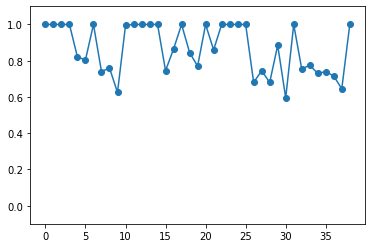

In [89]:
plt.plot(accuracy,'-o')
plt.ylim([-0.1,1.1])

In [90]:
spl=nx.shortest_path_length(nx.from_numpy_array(connectivity.adj_matrix),drain_pool[1],drain_pool[0])

In [91]:
spl

9

In [92]:
((onAmp-sim[0].wireVoltage[:,drain_pool[0]])/spl)

array([0.22222222, 0.22769649, 0.23316656, 0.23863243, 0.24409409,
       0.24955156, 0.25500484, 0.26045393, 0.26589882, 0.27133826,
       0.2767596 , 0.28219714, 0.28760649, 0.29301199, 0.29841687,
       0.30382498, 0.30919354, 0.31451004, 0.31980326, 0.32508009,
       0.3303468 , 0.33560402, 0.34080545, 0.34598339, 0.35114876,
       0.35630014, 0.36142253, 0.36651407, 0.37155367, 0.37650473,
       0.38135706, 0.38604634, 0.39031126, 0.39326089, 0.22222222,
       0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222

In [93]:
sampleTimes=numDT*(nbacks[0]+1)

In [94]:
signalLen=200*len(alltargets)

In [95]:
nback=nbacks[0]
tmp=numDT*nback
A=np.array(range(tmp,signalLen,int(tmp+numDT))) #training 
B=np.array(range(tmp+numDT,signalLen,int(tmp+numDT)))# testing
c=[]
for k in range(len(B)):
    c.append(range(A[k],B[k]))
testTimes=np.array(np.hstack(c))
l=range(signalLen)
trainTimes=np.array(np.hstack([m for m in l if m not in testTimes]))

#test and train samples:
testSamples=[]
for i in range(-1,len(alltargets),3):
    if i > 0:
        testSamples.append(i)
testSamples=np.array(testSamples)
trainSamples = np.setdiff1d(np.array(range(len(alltargets))),testSamples)

In [96]:
drain1=[];drain2=[]
for i in range(len(t)-2):
    drain1.append(t[i][0])
    drain2.append(t[i][1])
    
drain1test=np.array(drain1)[testSamples]
drain2test=np.array(drain2)[testSamples]

targets=np.array(alltargets)[testSamples]

In [97]:
import pandas as pd
# trainingLabels=allLabels #not sure about this
nback=nbacks[0]
thisTrainInputs=[[] for i in range(len(trainingLabels))]
for trial in tqdm(range(len(trainingLabels))): #for each trial
    #bin training samples
    thisLabels=np.array(allLabels)
    tmp=trainingInputs[trainingOrder]
    
    #plot training inputs that are to be tested:
    count = 0
    for inpt in tmp:
        thisTrainInputs[count]=(inpt.reshape(-1,1))
        count+=1
    trainlabel=trainingLabels
#     trainlabel=np.delete(trainlabel,np.arange(nback,trainlabel.size,nback+1))
    trainlabel=np.array(trainlabel).reshape(-1, nback)
    thisTestTime = testTimes
    targetTimes = signal_expand(targets,numDT)
    
    currents=np.array(t)
    thisTarget=targets
    testlabel=testingLabels[:numTestingSamples]
        
    if nback == 2:    
        #seperate to classes 

        c1c1notest=[0]
        c1c2notest=[0]
        c2c1notest=[0]
        c2c2notest=[0]
        count1=0
        count2=0
        c2count=[]
        c1count=[]
        classOrder=[]
        targetClass=[]
        for label in trainlabel:
            if np.all(label == [0,0]):
                classOrder.append('c1-c1')
                targetClass.append(1)
                count1+=1
            elif np.all(label == [0,1]):
                classOrder.append('c1-c2')
                targetClass.append(1)
                count1+=1
            elif np.all(label == [1,1]):
                classOrder.append('c2-c2')
                targetClass.append(2)
                count2+=1
            elif np.all(label == [1,0]):
                classOrder.append('c2-c1')
                targetClass.append(2)
                count2+=1
            c2count.append(count2)
            c1count.append(count1)
       #count how many times the network has seen c1-c1,c1-c2/c2-c1,c2-c2 at each test point:
        for i in range(len(trainlabel)):
            a=np.sum(np.array_equiv(trainlabel[i],np.array([0,0])))
            b=np.sum(np.array_equiv(trainlabel[i],np.array([0,1])))
            c=np.sum(np.array_equiv(trainlabel[i],np.array([1,0])))
            d=np.sum(np.array_equiv(trainlabel[i],np.array([1,1])))

    #         set_trace()
            c1c1notest.append(c1c1notest[i]+a)
            c1c2notest.append(c1c2notest[i]+b)
            c2c1notest.append(c2c1notest[i]+c)
            c2c2notest.append(c2c2notest[i]+d)


        #count how many times the network has seen c1/c2 at each test point:
        count1notest=[]
        count2notest=[]
        temp1=trainlabel.reshape(-1)
        for i in range(len(temp1)):
            if i == 0:
                count1notest.append(0)
                count2notest.append(0)
            if i % nback == 0 and i > 0:
                count1notest.append(np.sum(temp1[:i]==0))
                count2notest.append(np.sum(temp1[:i]==1))

        count1plustest=[]
        count2plustest=[]
        temp1=thisLabels
        n=nback+1
        for i in range(len(temp1)):
            if i == 0:
                count1plustest.append(0)
                count2plustest.append(0)
            if i % n == 0 and i > 0: 
                count1plustest.append(np.sum(temp1[:i]==0))
                count2plustest.append(np.sum(temp1[:i]==1))            

        cumsumdiffnotest=np.array(count1notest)-np.array(count2notest)
        cumsumdifftest=np.array(count1plustest)-np.array(count2plustest)    

        if len(accuracy)!= len(targetClass):
            temp=np.append(accuracy,np.nan)
#         set_trace()
        df=pd.DataFrame({'Class':np.array(targetClass),'Order':classOrder,'Trial':trial,
                         'Accuracy':temp,'C1NoTest':count1notest,
                         'C2NoTest':count2notest,'CountDiff':np.array(c2count)-np.array(c1count),
                         'C1+Test':count1plustest,'C2+Test':count2plustest,'C1C1count':c1c1notest[1:],
                         'C1C2count':c1c2notest[1:], 'C2C1count':c2c1notest[1:],'C2C2count':c2c2notest[1:],
                        })
   
#     elif nback == 3:    

#         count1=0
#         count2=0
#         c2count=[]
#         c1count=[]
#         classOrder=[]
#         targetClass=[]
#         for label in trainlabel:
#             if np.all(label == [0,0,0]):
#                 classOrder.append('c1-c1-c1')
#                 targetClass.append(1)
#                 count1+=1
#             elif np.all(label == [0,1,0]):
#                 classOrder.append('c1-c2-c1')
#                 targetClass.append(1)
#                 count1+=1
#             elif np.all(label == [0,1,1]):
#                 classOrder.append('c1-c2-c2')
#                 targetClass.append(1)
#                 count1+=1
#             elif np.all(label == [0,0,1]):
#                 classOrder.append('c1-c1-c2')
#                 targetClass.append(1)
#                 count1+=1   
#             elif np.all(label == [1,1,1]):
#                 classOrder.append('c2-c2-c2')
#                 targetClass.append(2)
#                 count2+=1
#             elif np.all(label == [1,0,1]):
#                 classOrder.append('c2-c1-c2')
#                 targetClass.append(2)
#                 count2+=1
#             elif np.all(label == [1,1,0]):
#                 classOrder.append('c2-c2-c1')
#                 targetClass.append(2)
#                 count2+=1
#             elif np.all(label == [1,0,0]):
#                 classOrder.append('c2-c1-c1')
#                 targetClass.append(2)
#                 count2+=1
#             c2count.append(count2)
#             c1count.append(count1)
#        #count how many times the network has seen c1-c1,c1-c2/c2-c1,c2-c2 at each test point:
#         c1c1c1notest=[0];c2c2c2notest=[0];
#         c1c1c2notest=[0];c2c2c1notest=[0];
#         c1c2c2notest=[0];c2c1c2notest=[0];
#         c1c2c1notest=[0];c2c1c1notest=[0];
        
#         for i in range(len(trainlabel)):
#             a1=np.sum(np.array_equiv(trainlabel[i],np.array([0,0,0])))
#             b1=np.sum(np.array_equiv(trainlabel[i],np.array([0,0,1])))
#             c1=np.sum(np.array_equiv(trainlabel[i],np.array([0,1,0])))
#             d1=np.sum(np.array_equiv(trainlabel[i],np.array([0,1,1])))
#             a2=np.sum(np.array_equiv(trainlabel[i],np.array([1,1,1])))
#             b2=np.sum(np.array_equiv(trainlabel[i],np.array([1,0,1])))
#             c2=np.sum(np.array_equiv(trainlabel[i],np.array([1,1,0])))
#             d2=np.sum(np.array_equiv(trainlabel[i],np.array([1,0,0])))
            
#     #         set_trace()
#             c1c1c1notest.append(c1c1c1notest[i]+a1)
#             c1c1c2notest.append(c1c1c2notest[i]+b1)
#             c1c2c1notest.append(c1c2c1notest[i]+c1)
#             c1c2c2notest.append(c1c2c1notest[i]+d1)
#             c2c2c2notest.append(c2c2c2notest[i]+a2)
#             c2c1c2notest.append(c1c1c2notest[i]+b2)
#             c2c2c1notest.append(c1c2c1notest[i]+c2)
#             c2c1c1notest.append(c1c2c1notest[i]+d2)


#         #count how many times the network has seen c1/c2 at each test point:
#         count1notest=[]
#         count2notest=[]
#         temp1=trainlabel.reshape(-1)
#         for i in range(len(temp1)):
#             if i == 0:
#                 count1notest.append(0)
#                 count2notest.append(0)
#             if i % nback == 0 and i > 0:
#                 count1notest.append(np.sum(temp1[:i]==0))
#                 count2notest.append(np.sum(temp1[:i]==1))

#         count1plustest=[]
#         count2plustest=[]
#         temp1=thisLabels
#         n=nback+1
#         for i in range(len(temp1)):
#             if i == 0:
#                 count1plustest.append(0)
#                 count2plustest.append(0)
#             if i % n == 0 and i > 0: 
#                 count1plustest.append(np.sum(temp1[:i]==0))
#                 count2plustest.append(np.sum(temp1[:i]==1))            

#         cumsumdiffnotest=np.array(count1notest)-np.array(count2notest)
#         cumsumdifftest=np.array(count1plustest)-np.array(count2plustest)    

#         df=pd.DataFrame({'Class':np.array(targetClass),'Order':classOrder,'Trial':trial,
#                          'Accuracy':temp,'C1NoTest':count1notest,
#                          'C2NoTest':count2notest,'CountDiff':np.array(c2count)-np.array(c1count),
#                          'C1+Test':count1plustest,'C2+Test':count2plustest,'C1C1C1count':c1c1c1notest[1:],
#                          'C1C1C2count':c1c1c2notest[1:],'C1C2C2count':c1c2c2notest[1:],'C1C2C1count':c1c2c1notest[1:],
#                          'C2C2C2count':c2c2c2notest[1:],'C2C2C1count':c2c2c1notest[1:],'C2C1C1count':c2c1c1notest[1:],
#                          'C2C1C2count':c2c1c2notest[1:]
#                         })
    
    
    counts=[]
    for i in range(len(df)):
        counts.append(i)
        
    d = {'OrderVal':counts,'Train Time Start':((np.array(counts)+1)*numDT*3)-numDT*3,
                     'Train Time End':((np.array(counts)+1)*numDT*3)-numDT-1,
                     'Test Time Start':(np.array(counts)+1)*numDT*3-numDT,
                     'Test Time End':(np.array(counts)+1)*numDT*3-1,}
    df = df.join(pd.DataFrame(d, index=df.index))
    
#     if trial == 0:
#         newdf=df
#     else:
#         newdf=newdf.append(df)
#     newdf.index=range(len(newdf))

  0%|          | 0/80 [00:00<?, ?it/s]

In [98]:
df

,Class,Order,Trial,Accuracy,C1NoTest,C2NoTest,CountDiff,C1+Test,C2+Test,C1C1count,C1C2count,C2C1count,C2C2count,OrderVal,Train Time Start,Train Time End,Test Time Start,Test Time End
0,1,c1-c1,79,1.000,0,0,-1,0,0,1,0,0,0,0,0,399,400,599
1,1,c1-c2,79,1.000,2,0,-2,3,0,1,1,0,0,1,600,999,1000,1199
2,1,c1-c2,79,1.000,3,1,-3,5,1,1,2,0,0,2,1200,1599,1600,1799
3,1,c1-c2,79,1.000,4,2,-4,7,2,1,3,0,0,3,1800,2199,2200,2399
4,2,c2-c2,79,0.820,5,3,-3,9,3,1,3,0,1,4,2400,2799,2800,2999
5,1,c1-c2,79,0.805,5,5,-4,9,6,1,4,0,1,5,3000,3399,3400,3599
6,1,c1-c2,79,1.000,6,6,-5,11,7,1,5,0,1,6,3600,3999,4000,4199
7,2,c2-c2,79,0.740,7,7,-4,13,8,1,5,0,2,7,4200,4599,4600,4799
8,1,c1-c2,79,0.760,7,9,-5,13,11,1,6,0,2,8,4800,5199,5200,5399
9,2,c2-c1,79,0.625,8,10,-4,15,12,1,6,1,2,9,5400,5799,5800,5999


In [99]:
# #Save data for loading:
saveName='data_350nw_1350nj_3x3_wThresh_Vtrn2_Vtst0p5_beta005_T200'
with open(dataLoc+saveName+'.pkl', 'wb') as f:
    pickle.dump(df, f)   
# #Save data for GLMFIT and Functional Analysis:
# savemat(dataLoc+'nback'+str(nback)+'_vt_target_350nw_1350nj_reinforcement_nback2.mat',{'Data':{'EdgeVoltage':vtj,'EdgeConductance':gtj,'EdgeCurrent':ctj,'NodeVoltage':vt,'Target':tar}})

In [71]:
dfAccuracy = df.groupby('Order').agg([np.mean,np.std])
dfAccuracy= dfAccuracy['Accuracy']

In [72]:
dfAccuracy

,mean,std
Order,,
c1-c1,0.991875,0.014126
c1-c2,0.972500,0.049886
c2-c1,0.969545,0.038695
c2-c2,0.908125,0.170167


In [73]:
targetsNew=[]
for t in alltargets:
    targetsNew.append(int(t[0]))

In [74]:
len(targetsNew)

119

In [75]:
sampleTimes=numDT*(nbacks[0]+1)

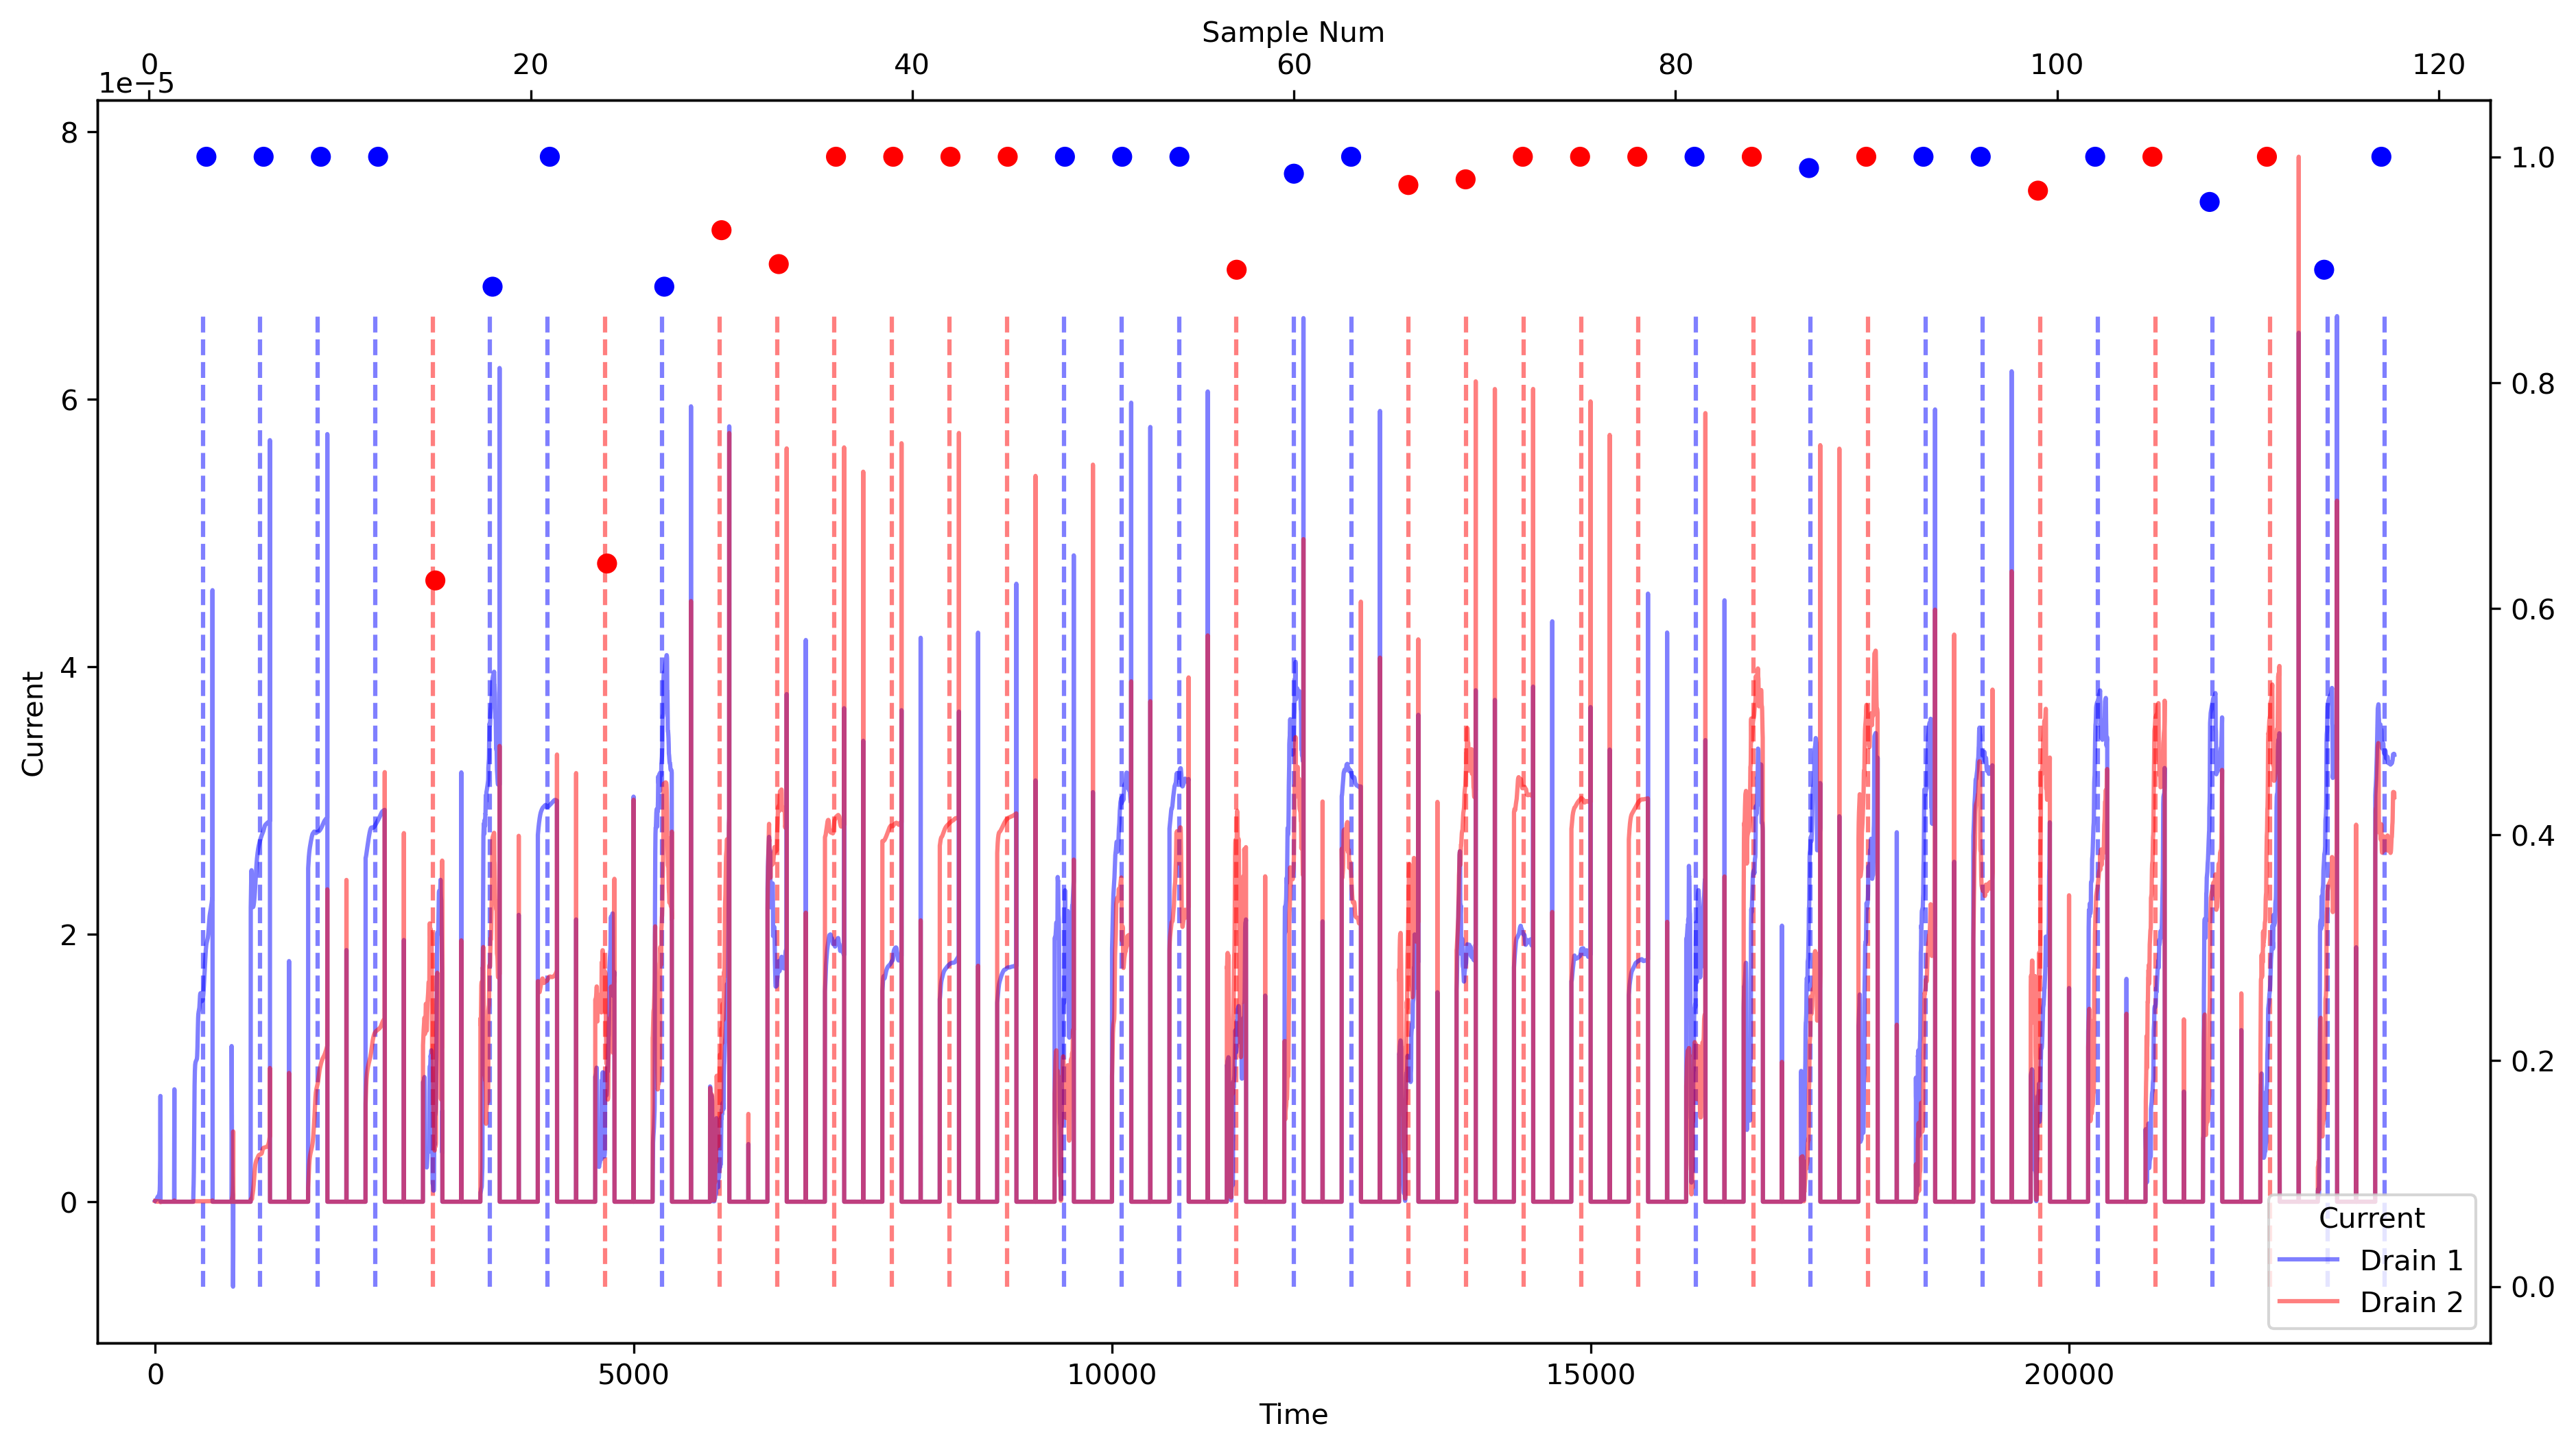

In [76]:
#Current Strength vs Accuracy:
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42


fig,ax = plt.subplots(1,1, figsize=(15, 8), dpi=300)
x=np.concatenate(drain1)
p1=ax.plot(x,'b',alpha=0.5)
p2=ax.plot(np.concatenate(drain2),'r',alpha=0.5)
plt.legend([p1[0],p2[0]],['Drain 1','Drain 2'],loc='lower right',title='Current')


if nback == 1:
    xlimmax=830
    vlinesStep=40
    vlinesStart=30
    dotpos=2

if nback == 2:
#     xlimmax=1230
    vlinesStep=600
    vlinesStart=500
    dotpos=3
elif nback == 3:
    xlimmax=1630
    vlinesStep=80
    vlinesStart=70
    dotpos=4
    
colrs=[]
for val in targetsNew:
    if val < 1:
        colrs.append('C1')
    else:
        colrs.append('C2')    

testColors=[]
for i in colrs[::3]:
    if i == 'C1':
        testColors.append('b')
    else:
        testColors.append('r')
        
ax.set_xlabel('Time')
ax.set_ylabel('Current')
ax.set_xlim([-600,24400])

ax.vlines(range(vlinesStart,len(x)-20,vlinesStep),np.min(x),np.max(x),linestyle='dashed',color=testColors,alpha=0.5)

ax2=ax.twinx().twiny()
ax2.scatter(list(range(3,120,3)),df['Accuracy'][:-1],c=testColors[:-1])
ax2.set_ylim([-0.05,1.05])

# ax2.set_xticklabels(np.array(range(0,121,20)))#np.round(np.array(range(vlinesStart,len(x)-20,vlinesStep))/39)-1)

# testTimeVals=np.array(range(len(accuracy)))*dotpos+dotpos


# ax2.scatter(x=range(vlinesStart,len(x)-20,vlinesStep),y=accuracy,c=testColors)

ax2.set_xlabel('Sample Num')
ax2.set_ylabel('Accuracy')
# sns.scatterplot(x=testTimeVals,y='Accuracy',data=accuracy,hue=colrs[:-1],palette=['r','b'],ax=ax2)
# ax2.legend(title='Accuracy',loc='lower left')
# ax2.set_xlim([-20/20,(xlimmax+10)/20])
# ax2.set_ylabel('Accuracy')

# ax3=ax2.twinx()
# p1=ax3.plot(testTimeVals[:-1],count1plustest[:-1],color='c',marker='x')
# p2=ax3.plot(testTimeVals[:-1],count2plustest[:-1],color='m',marker='x')
# ax3.set_xlim([-20/20,1240/20])

# plt.vlines(range(3,testTimeVals.values[-1],3),0,1,linestyle='dashed',color='k',)
if patternSize==2:
    fig.savefig(saveFig+saveName+'.pdf',format='pdf',dpi=300)
# else:
#     fig.savefig(saveFig+'350w_1350j_current_time_accuracy_nback2_3x3_manualsources_reinforcement.pdf',format='pdf',dpi=300)


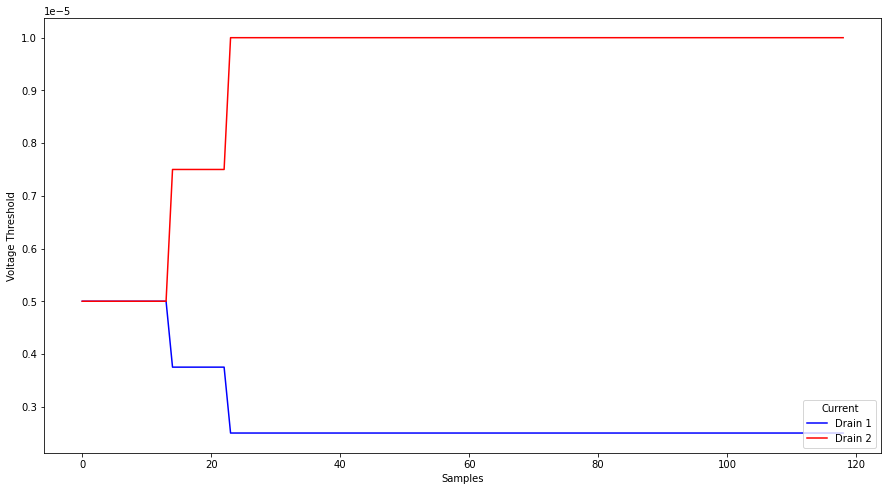

In [77]:
fig=plt.figure(figsize=(15,8))
p1=plt.plot(np.array(thresholds)[:,0],c='b')
p2=plt.plot(np.array(thresholds)[:,1],c='r')
plt.xlabel('Samples')
plt.ylabel('Voltage Threshold')
plt.legend([p1[0],p2[0]],['Drain 1','Drain 2'],loc='lower right',title='Current')
if patternSize==2:
    fig.savefig(saveFig+saveName+'_threshValues.pdf',format='pdf',dpi=300)
else:
    fig.savefig(saveFig+saveName+'_threshValues.pdf',format='pdf',dpi=300)

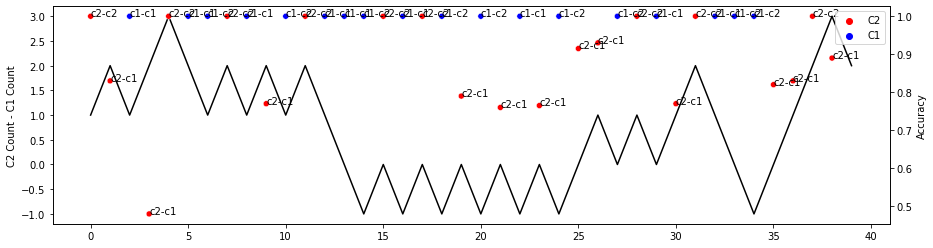

In [49]:
fig,ax=plt.subplots(1,figsize=(15,4))

colrs=[]
for val in df['Class']:
    if val <= 1:
        colrs.append('C1')
    else:
        colrs.append('C2')


x=df['CountDiff']

p1=ax.plot(range(len(x)),x,color='k')
ax2=ax.twinx()

sns.scatterplot(x='OrderVal',y='Accuracy',data=df,hue=colrs,palette=['r','b'],ax=ax2)
ax.set_ylabel('C2 Count - C1 Count')

z=df['OrderVal'].values
y=df['Accuracy'].values
for i, txt in enumerate(df['Order']):
    ax2.annotate(txt, (z[i], y[i]))
# p2=ax.plot(range(len(c1c2notest[1:])),c1c2notest[1:],color='b',marker='^')
# ax.legend([p1[0],p2[0]],['C1-C1','C1-C2'],loc='best',title='CumCount')
if patternSize==2:
    fig.savefig(saveFig+'350w_1350j_classComparison_nback2_2x2_reinforcement.pdf',format='pdf',dpi=300)
else:
    fig.savefig(saveFig+'350w_1350j_classComparison_nback2_3x3_manualsources_reinforcement.pdf',format='pdf',dpi=300)


Text(0.5, 1.0, 'CumCount Class and Accuracy | With Test Values')

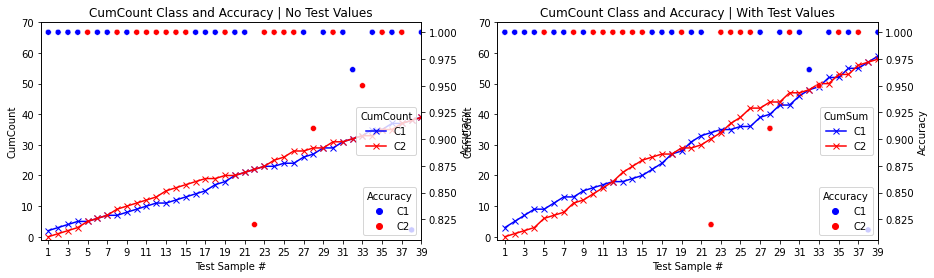

In [138]:
fig,axes=plt.subplots(1,2,figsize=(15,4))

ax=axes[0]

p1=ax.plot(range(len(count1notest[1:])),count1notest[1:],color='b',marker='x')
p2=ax.plot(range(len(count2notest[1:])),count2notest[1:],color='r',marker='x')
ax.legend([p1[0],p2[0]],['C1','C2'],loc='right',title='CumCount')

ax.set_xlim([-0.75,18.75])
ax.set_ylim([-1,70])
ax.set_ylabel('CumCount')
ax.set_xlabel('Test Sample #')

ax.set_xticks(np.array(np.arange(0,len(count2notest[1:]),2)))

ax.set_xticklabels(np.array(np.arange(0,len(count2notest[1:]),2))+1)
ax2=ax.twinx()
# plt.plot(temp,'o',c='k')

colrs=[]
for val in df['Class']:
    if val <= 1:
        colrs.append('C1')
    else:
        colrs.append('C2')
        
        
sns.scatterplot(x='OrderVal',y='Accuracy',data=df,hue=colrs,palette=['b','r'],ax=ax2)
# p3=plt.scatter(np.array(range(len(targetClass))),temp,marker='x',color=colrs,label=['C1','C2'])
plt.legend(title='Accuracy',loc='lower right')
ax2.set_title('CumCount Class and Accuracy | No Test Values')
# plt.plot(np.array(targetClass)-1,'_')

ax1=axes[1]
p1=ax1.plot(range(len(count1plustest[1:])),count1plustest[1:],color='b',marker='x')
p2=ax1.plot(range(len(count2plustest[1:])),count2plustest[1:],color='r',marker='x')
ax1.legend([p1[0],p2[0]],['C1','C2'],loc='right',title='CumSum')
ax1.set_xlim([-0.75,18.75])
ax1.set_ylim([-1,70])
ax1.set_ylabel('CumCount')
ax1.set_xlabel('Test Sample #')

ax1.set_xticks(np.array(np.arange(0,len(count2notest[1:]),2)))

ax1.set_xticklabels(np.array(np.arange(0,len(count2notest[1:]),2))+1)
ax3=ax1.twinx()
      
sns.scatterplot(x='OrderVal',y='Accuracy',data=df,hue=colrs,palette=['b','r'],ax=ax3)
# p3=plt.scatter(np.array(range(len(targetClass))),temp,marker='x',color=colrs,label=['C1','C2'])
ax3.legend(title='Accuracy',loc='lower right')
ax3.set_title('CumCount Class and Accuracy | With Test Values')
# plt.plot(np.array(targetClass)-1,'_')

Text(0.5, 1.0, 'CumCount Pairings and Accuracy | C2 Pairings')

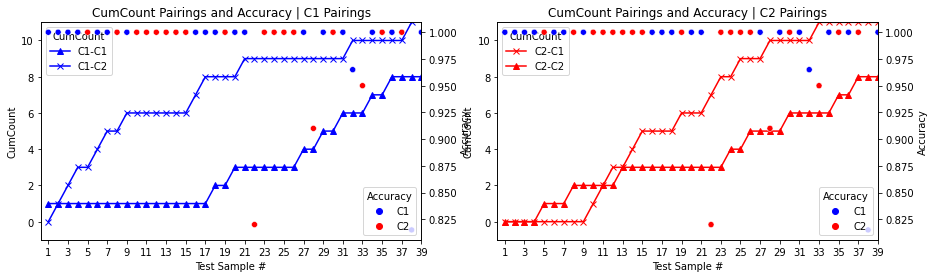

In [139]:
import seaborn as sns

fig,axes=plt.subplots(1,2,figsize=(15,4))

ax=axes[0]

p1=ax.plot(range(len(c1c1notest[1:])),c1c1notest[1:],color='b',marker='^')
p2=ax.plot(range(len(c1c2notest[1:])),c1c2notest[1:],color='b',marker='x')
ax.legend([p1[0],p2[0]],['C1-C1','C1-C2'],loc='best',title='CumCount')

ax.set_xlim([-0.75,19.75])
ax.set_ylim([-1,11])
ax.set_ylabel('CumCount')
ax.set_xlabel('Test Sample #')

ax.set_xticks(np.array(np.arange(0,len(count2notest[1:]),2)))

ax.set_xticklabels(np.array(np.arange(0,len(count2notest[1:]),2))+1)
ax2=ax.twinx()
# plt.plot(temp,'o',c='k')

colrs=[]
for val in df['Class']:
    if val <= 1:
        colrs.append('C1')
    else:
        colrs.append('C2')
        
        
sns.scatterplot(x='OrderVal',y='Accuracy',data=df,hue=colrs,palette=['b','r'],ax=ax2)
# p3=plt.scatter(np.array(range(len(targetClass))),temp,marker='x',color=colrs,label=['C1','C2'])
plt.legend(title='Accuracy',loc='lower right')
ax2.set_title('CumCount Pairings and Accuracy | C1 Pairings')
# plt.plot(np.array(targetClass)-1,'_')

ax1=axes[1]
p3=ax1.plot(range(len(c2c1notest[1:])),c2c1notest[1:],color='r',marker='x')
p4=ax1.plot(range(len(c2c2notest[1:])),c2c2notest[1:],color='r',marker='^')
ax1.legend([p3[0],p4[0]],['C2-C1','C2-C2'],loc='best',title='CumCount')
ax1.set_xlim([-0.75,19.75])
ax1.set_ylim([-1,11])
ax1.set_ylabel('CumCount')
ax1.set_xlabel('Test Sample #')

ax1.set_xticks(np.array(np.arange(0,len(count2notest[1:]),2)))

ax1.set_xticklabels(np.array(np.arange(0,len(count2notest[1:]),2))+1)
ax3=ax1.twinx()
      
sns.scatterplot(x='OrderVal',y='Accuracy',data=df,hue=colrs,palette=['b','r'],ax=ax3)
# p3=plt.scatter(np.array(range(len(targetClass))),temp,marker='x',color=colrs,label=['C1','C2'])
ax3.legend(title='Accuracy',loc='lower right')
ax3.set_title('CumCount Pairings and Accuracy | C2 Pairings')
# plt.plot(np.array(targetClass)-1,'_')